In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, balanced_accuracy_score, precision_score, recall_score, precision_recall_fscore_support
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split, StratifiedKFold
from scikeras.wrappers import KerasClassifier, KerasRegressor
from scipy.stats import gaussian_kde
from sklearn.utils.class_weight import compute_class_weight
from joblib import Parallel, delayed


In [2]:
train_data = np.load('fashion_train.npy')
test_data = np.load('fashion_test.npy')

# Ensure that train_images and test_images are prepared from train_data and test_data respectively
train_images = train_data[:, :-1]  # Extract image data
train_labels = train_data[:, -1]    # Extract labels

test_images = test_data[:, :-1]     # Extract test image data
test_labels = test_data[:, -1]       # Extract test labels

# Normalize the pixel values
train_images = train_images / 255.0
test_images = test_images / 255.0

# Reshape images into 28x28 for visualization and further processing
train_images = train_images.reshape(-1, 28, 28)
test_images = test_images.reshape(-1, 28, 28)


# Define class names for Fashion-MNIST
class_names = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Shirt',
]

# Flatten the training images (from 28x28) to (784,) for each image
train_images_flat = train_images.reshape(train_images.shape[0], -1)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images_flat, train_labels, test_size=0.2, random_state=42)

# Check the new shape
print(f"Flattened train images shape: {train_images_flat.shape}")  # Should be (number_of_train_samples, 784)

# Flatten the test images (from 28x28) to (784,) for each image
test_images_flat = test_images.reshape(test_images.shape[0], -1)

# Check the new shape
print(f"Flattened test images shape: {test_images_flat.shape}")  # Should be (number_of_test_samples, 784)

Flattened train images shape: (10000, 784)
Flattened test images shape: (5000, 784)


In [3]:
# Check the shapes to ensure separation worked
print(f"Train Images shape: {train_images.shape}")  # Should be (15000, 28, 28)
print(f"Train Labels shape: {train_labels.shape}")  # Should be (10000,)
print(f"Test Images shape: {test_images.shape}")    # Should be (10000, 28, 28)
print(f"Test Labels shape: {test_labels.shape}")    # Should be (10000,)

Train Images shape: (10000, 28, 28)
Train Labels shape: (10000,)
Test Images shape: (5000, 28, 28)
Test Labels shape: (5000,)


Flattened train images shape: (10000, 784)
Flattened test images shape: (5000, 784)


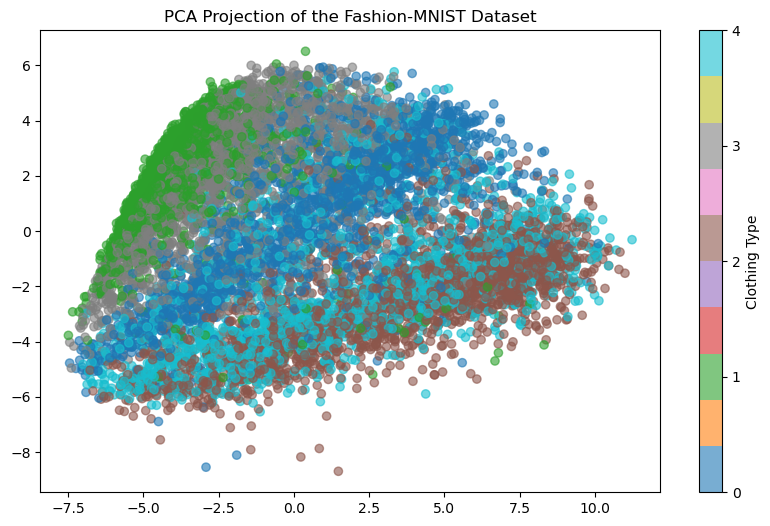

In [4]:
# Flatten images for training and test sets
train_images_flat = train_images.reshape(train_images.shape[0], -1)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

# Check the new shape
print(f"Flattened train images shape: {train_images_flat.shape}")  # Should be (train_samples, 784)
print(f"Flattened test images shape: {test_images_flat.shape}")    # Should be (test_samples, 784)

# Apply PCA
pca = PCA(n_components=11)
train_pca = pca.fit_transform(train_images_flat)

# Visualize PCA result
plt.figure(figsize=(10, 6))
scatter = plt.scatter(train_pca[:, 0], train_pca[:, 1], c=train_labels, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, ticks=np.arange(10), label='Clothing Type')
plt.title("PCA Projection of the Fashion-MNIST Dataset")
plt.show()

    

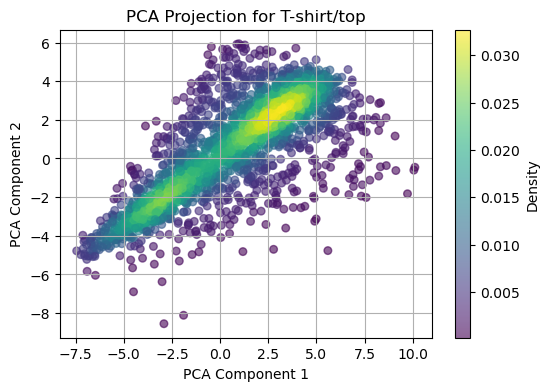

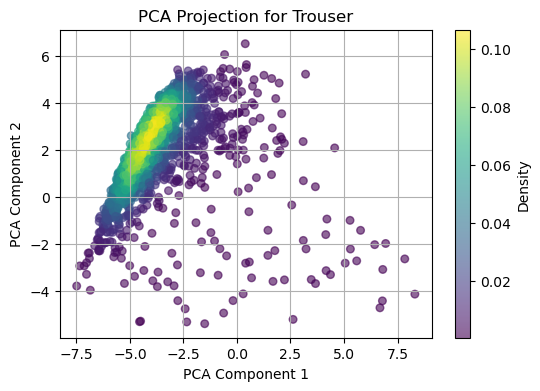

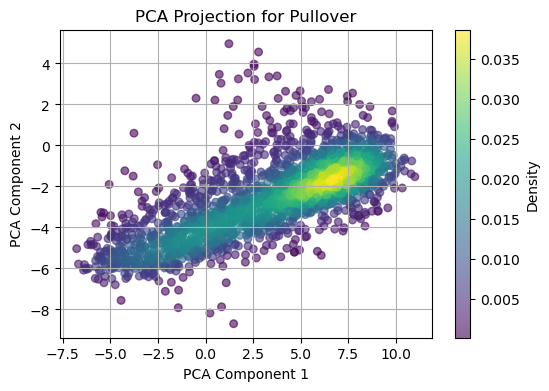

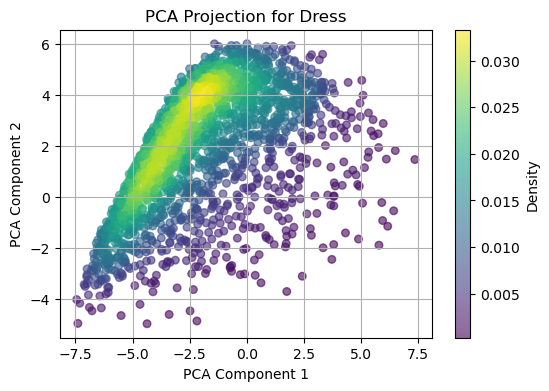

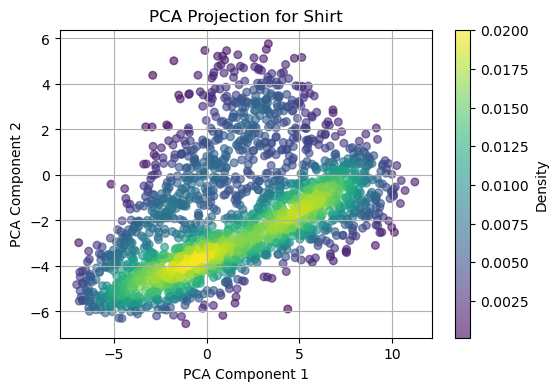

In [5]:
unique_labels = np.unique(train_labels)

for label in unique_labels:
    plt.figure(figsize=(6, 4))
    mask = train_labels == label
    data = train_pca[mask, :2]
    x, y = data.T
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    
    plt.scatter(x, y, c=z, s=30, alpha=0.6)
    plt.colorbar(label='Density')
    plt.title(f"PCA Projection for {class_names[label]}")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    
    # Érvénytelen karakterek cseréje a fájlnévben
    safe_class_name = class_names[label].replace('/', '_')
    plt.savefig(f'pca_projection_{safe_class_name}.png')
    
    plt.show()
    


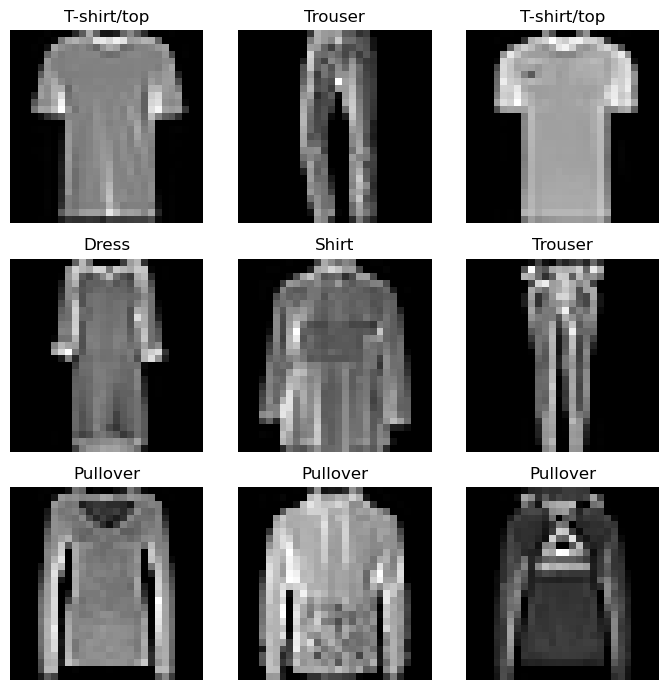

In [6]:
# Plot sample images
def plot_sample_images(images, labels, class_names, samples=9):
    plt.figure(figsize=(7, 7))
    for i in range(samples):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(class_names[int(labels[i])])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display the first 9 images from the training set
plot_sample_images(train_images, train_labels, class_names)

### Decision tree from scratch

In [7]:
class DecisionTree:
    def __init__(self, max_depth=None, class_weight=None):
        self.max_depth = max_depth
        self.class_weight = class_weight
        self.tree = None
        
    class Node:
        __slots__ = ['feature', 'threshold', 'left', 'right', 'output']
        def __init__(self, feature=None, threshold=None, left=None, right=None, output=None):
            self.feature = feature
            self.threshold = threshold
            self.left = left
            self.right = right
            self.output = output

    def fit(self, X, y):
        self.n_classes = len(np.unique(y))
        self.tree = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples = X.shape[0]
        if (self.max_depth and depth >= self.max_depth) or n_samples < 2:
            return self.Node(output=np.bincount(y).argmax())

        best_feature, best_threshold, best_gain = self._find_best_split(X, y)
        if best_gain <= 0:
            return self.Node(output=np.bincount(y).argmax())

        mask = X[:, best_feature] < best_threshold
        left_node = self._grow_tree(X[mask], y[mask], depth + 1)
        right_node = self._grow_tree(X[~mask], y[~mask], depth + 1)

        return self.Node(feature=best_feature, threshold=best_threshold, 
                         left=left_node, right=right_node)

    def _find_best_split(self, X, y):
        n_features = X.shape[1]
        best_gain = -np.inf
        best_feature = None
        best_threshold = None
        current_entropy = self._entropy(y)

        for feature in range(n_features):
            feature_values = X[:, feature]
            thresholds = np.unique(feature_values)[:-1]
            if len(thresholds) == 0:
                continue

            gains = np.array([
                self._fast_information_gain(feature_values, y, threshold, current_entropy)
                for threshold in thresholds
            ])

            max_gain_idx = gains.argmax()
            if gains[max_gain_idx] > best_gain:
                best_gain = gains[max_gain_idx]
                best_feature = feature
                best_threshold = thresholds[max_gain_idx]

        return best_feature, best_threshold, best_gain

    def _fast_information_gain(self, feature_values, y, threshold, parent_entropy):
        mask = feature_values < threshold
        left_counts = np.bincount(y[mask], minlength=self.n_classes)
        right_counts = np.bincount(y[~mask], minlength=self.n_classes)

        n_left = mask.sum()
        n_right = len(y) - n_left
        if n_left == 0 or n_right == 0:
            return 0

        p_left = n_left / len(y)
        p_right = n_right / len(y)

        left_entropy = self._fast_entropy(left_counts)
        right_entropy = self._fast_entropy(right_counts)

        return parent_entropy - (p_left * left_entropy + p_right * right_entropy)

    @staticmethod
    def _fast_entropy(counts):
        probs = counts[counts > 0] / counts.sum()
        return -(probs * np.log2(probs)).sum()

    def _entropy(self, y):
        counts = np.bincount(y)
        probs = counts[counts > 0] / len(y)
        return -(probs * np.log2(probs)).sum()

    def predict(self, X):
        return np.array([self._predict(x) for x in X])

    def _predict(self, sample):
        node = self.tree
        while node.output is None:
            node = node.left if sample[node.feature] < node.threshold else node.right
        return node.output

## Cross validation for the decision tree from scratch


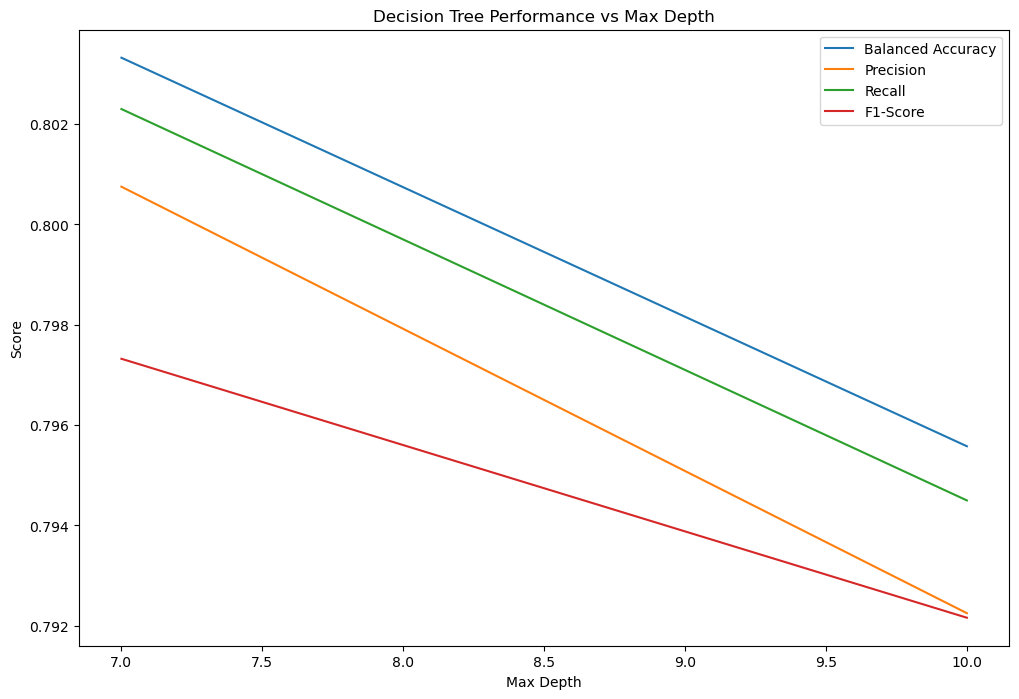

Best max_depth: 7


In [8]:
def evaluate_depth(depth, X, y, skf, class_weight_dict):
    fold_scores = []
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        tree = DecisionTree(max_depth=depth, class_weight=class_weight_dict)
        tree.fit(X_train, y_train)
        y_pred = tree.predict(X_val)

        balanced_accuracy = balanced_accuracy_score(y_val, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average='weighted')
        fold_scores.append((balanced_accuracy, precision, recall, f1))

    mean_scores = np.mean(fold_scores, axis=0)
    std_scores = np.std(fold_scores, axis=0)
    return (depth, *mean_scores, *std_scores)

def cross_validate_decision_tree(X, y, max_depths, n_splits=3):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weight_dict = dict(zip(np.unique(y), class_weights))

    results = Parallel(n_jobs=-1)(delayed(evaluate_depth)(depth, X, y, skf, class_weight_dict) for depth in max_depths)
    return results

# Usage
max_depths = [7, 10]
cv_results = cross_validate_decision_tree(train_images_flat, train_labels, max_depths)

# Plot results
depths, mean_bal_acc, mean_precision, mean_recall, mean_f1, *_ = zip(*cv_results)
plt.figure(figsize=(12, 8))
plt.plot(depths, mean_bal_acc, label='Balanced Accuracy')
plt.plot(depths, mean_precision, label='Precision')
plt.plot(depths, mean_recall, label='Recall')
plt.plot(depths, mean_f1, label='F1-Score')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title('Decision Tree Performance vs Max Depth')
plt.legend()
plt.savefig('decision_tree_performance_vs_max_depth.png')
plt.show()

# Find best depth based on F1-Score
best_depth = max(cv_results, key=lambda x: x[4])[0]  # Index 4 corresponds to mean F1-Score
print(f"Best max_depth: {best_depth}")

#### Evaluation of the model

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.82      0.78      1000
           1       0.94      0.92      0.93      1000
           2       0.74      0.86      0.80      1000
           3       0.82      0.85      0.84      1000
           4       0.68      0.49      0.57      1000

    accuracy                           0.79      5000
   macro avg       0.79      0.79      0.78      5000
weighted avg       0.79      0.79      0.78      5000



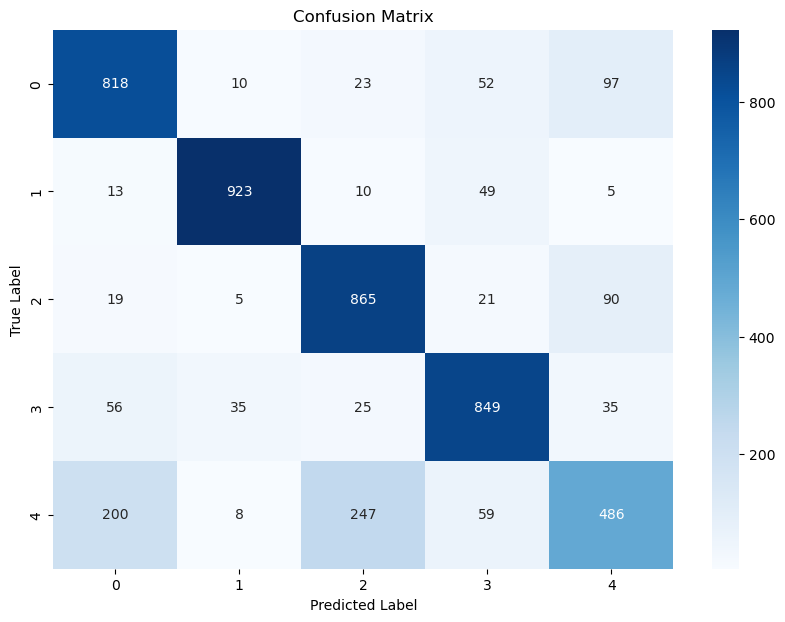

In [9]:
def evaluate_model(model, X_test, y_test):
    # Make predictions using the model
    predictions = model.predict(X_test)

    # Generate classification report
    report = classification_report(y_test, predictions)
    print("Classification Report:")
    print(report)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, predictions)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig('confusion_matrix_ogmodel.png')
    plt.show()

# Create and train the decision tree model
tree_model = DecisionTree(max_depth=7)
tree_model.fit(train_images_flat, train_labels)

# Evaluate the model
evaluate_model(tree_model, test_images_flat, test_labels)

### Decision tree with </em>scikit-learn</em>

In [10]:
# Initialize and train the model
dt_model = DecisionTreeClassifier(max_depth=7)
dt_model.fit(train_images_flat, train_labels)

# Predict on the test set
dt_predictions = dt_model.predict(test_images_flat)

# Evaluate the model
print("Decision Tree Classifier Results:")

# Check unique predicted labels
unique_predictions = np.unique(dt_predictions)
print(f"Unique predictions from Decision Tree Classifier: {unique_predictions}")

# Generate classification report with zero_division handling
print(classification_report(test_labels, dt_predictions, zero_division=0))


Decision Tree Classifier Results:
Unique predictions from Decision Tree Classifier: [0 1 2 3 4]
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1000
           1       0.97      0.91      0.94      1000
           2       0.75      0.87      0.81      1000
           3       0.83      0.86      0.84      1000
           4       0.65      0.55      0.60      1000

    accuracy                           0.79      5000
   macro avg       0.79      0.79      0.79      5000
weighted avg       0.79      0.79      0.79      5000



## Cross validation for the decision tree from scikit-learn


Optimal Tree Depth: 9


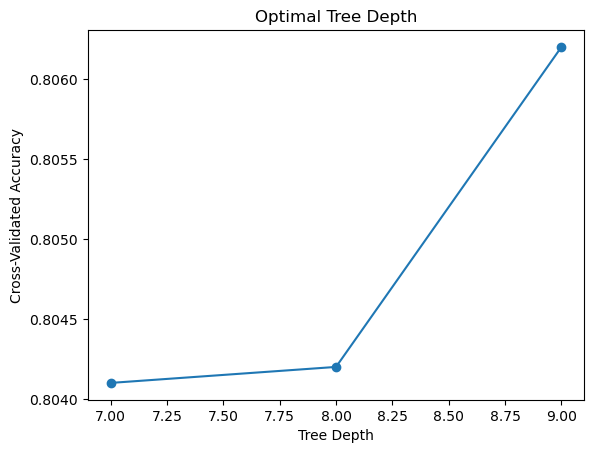

In [11]:
param_grid = {'max_depth': range(7, 10)}
tree = DecisionTreeClassifier()
grid_search = GridSearchCV(tree, param_grid, cv=5, n_jobs=-1)
grid_search.fit(train_images_flat, train_labels)

print(f"Optimal Tree Depth: {grid_search.best_params_['max_depth']}")

# Plot results
plt.plot(param_grid['max_depth'], grid_search.cv_results_['mean_test_score'], marker='o')
plt.xlabel('Tree Depth')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Optimal Tree Depth')
plt.savefig('optimal_tree_depth_scikit-learn.png')
plt.show()

#### Feed-forward neural networks

Epoch 1/100: Loss: 1.9850, Validation Precision: 0.7421
Epoch 2/100: Loss: 1.9947, Validation Precision: 0.7560
Epoch 3/100: Loss: 2.2479, Validation Precision: 0.7477
Epoch 4/100: Loss: 2.1826, Validation Precision: 0.7208
Epoch 5/100: Loss: 3.0054, Validation Precision: 0.6881
Epoch 6/100: Loss: 2.3333, Validation Precision: 0.7757
Epoch 7/100: Loss: 2.7085, Validation Precision: 0.6530
Epoch 8/100: Loss: 2.3052, Validation Precision: 0.7386
Epoch 9/100: Loss: 2.0694, Validation Precision: 0.6957
Epoch 10/100: Loss: 2.0631, Validation Precision: 0.5920
Epoch 11/100: Loss: 2.0041, Validation Precision: 0.7973
Epoch 12/100: Loss: 2.1891, Validation Precision: 0.7494
Epoch 13/100: Loss: 1.9613, Validation Precision: 0.7182
Epoch 14/100: Loss: 1.8492, Validation Precision: 0.6983
Epoch 15/100: Loss: 1.8774, Validation Precision: 0.7291
Epoch 16/100: Loss: 2.2971, Validation Precision: 0.6673
Epoch 17/100: Loss: 1.9005, Validation Precision: 0.7657
Epoch 18/100: Loss: 1.9248, Validation P

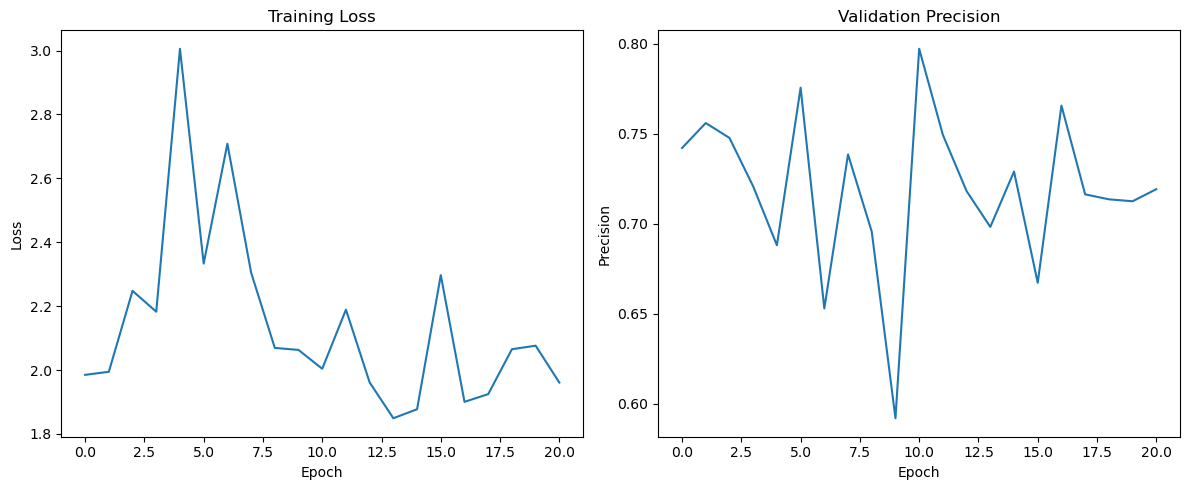

Test Accuracy: 0.7170, Test Loss: 0.6968


In [18]:
class NeuralNetwork:
    def __init__(self, layer_sizes, activation='relu'):
        self.num_layers = len(layer_sizes)
        self.weights = [np.random.randn(y, x) * np.sqrt(2 / x)
                        for x, y in zip(layer_sizes[:-1], layer_sizes[1:])]
        self.biases = [np.zeros((y, 1)) for y in layer_sizes[1:]]
        self.activation = activation
        self.epsilon = 1e-8  # For batch normalization

    def leaky_relu(self, x, alpha=0.01):
        return np.where(x > 0, x, alpha * x)

    def leaky_relu_derivative(self, x, alpha=0.01):
        return np.where(x > 0, 1, alpha)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))
        return exp_x / np.sum(exp_x, axis=0, keepdims=True)

    def forward_propagation(self, X, is_training=True):
        activations = [X]
        z_values = []
        for l in range(self.num_layers - 1):
            z = self.weights[l] @ activations[-1] + self.biases[l]
            z_values.append(z)
            
            if l == self.num_layers - 2:  # Output layer
                a = self.softmax(z)
            else:
                a = self.leaky_relu(z)
                
                if is_training:
                    a = np.random.binomial(1, 0.5, size=a.shape) * a / 0.5  # Dropout

            activations.append(a)
        return activations, z_values

    def backward_propagation(self, activations, z_values, y, class_weights, lambda_reg=0.01):
        m = activations[0].shape[1]
        delta = activations[-1] - y

        dW = [np.zeros_like(w) for w in self.weights]
        db = [np.zeros_like(b) for b in self.biases]

        for l in reversed(range(self.num_layers - 1)):
            dW[l] = (delta @ activations[l].T / m) + (lambda_reg / m) * self.weights[l]
            db[l] = np.sum(delta, axis=1, keepdims=True) / m

            if l > 0:
                delta = (self.weights[l].T @ delta) * self.leaky_relu_derivative(z_values[l-1])

        return dW, db

    def cross_entropy_loss(self, y_true, y_pred, class_weights):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        # Expand class_weights to match y_true's shape
        class_weights_expanded = class_weights[:, np.newaxis]
        weighted_loss = -np.sum(class_weights_expanded * y_true * np.log(y_pred)) / y_true.shape[1]
        return weighted_loss
    

    def train(self, X, y, epochs, learning_rate, class_weights, batch_size=32, lambda_reg=0.01, decay_rate=0.01):
        m = X.shape[1]
        losses = []
        for epoch in range(epochs):
            indices = np.random.permutation(m)
            X_shuffled = X[:, indices]
            y_shuffled = y[:, indices]
            
            for i in range(0, m, batch_size):
                X_batch = X_shuffled[:, i:i+batch_size]
                y_batch = y_shuffled[:, i:i+batch_size]

                activations, z_values = self.forward_propagation(X_batch)
                dW, db = self.backward_propagation(activations, z_values, y_batch, class_weights, lambda_reg)

                for l in range(self.num_layers - 1):
                    self.weights[l] -= learning_rate * dW[l]
                    self.biases[l] -= learning_rate * db[l]

            # Learning rate decay
            learning_rate *= (1 / (1 + decay_rate * epoch))
            
            # Calculate and store loss
            _, z_values = self.forward_propagation(X, is_training=False)
            loss = self.cross_entropy_loss(y, z_values[-1], class_weights)
            losses.append(loss)
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

        return losses

    def predict(self, X):
        activations, _ = self.forward_propagation(X, is_training=False)
        return activations[-1]

    def evaluate(self, X, y, class_weights):
        predictions = self.predict(X)
        accuracy = np.mean(np.argmax(predictions, axis=0) == np.argmax(y, axis=0))
        loss = self.cross_entropy_loss(y, predictions, class_weights)
        return accuracy, loss

    def train_with_early_stopping(self, X, y, X_val, y_val, epochs, learning_rate, class_weights, batch_size=32, patience=5, lambda_reg=0.01, decay_rate=0.01):
        m = X.shape[1]
        best_val_metric = -np.inf
        patience_counter = 0
        losses = []
        val_precisions = []

        for epoch in range(epochs):
            indices = np.random.permutation(m)
            X_shuffled = X[:, indices]
            y_shuffled = y[:, indices]
            
            for i in range(0, m, batch_size):
                X_batch = X_shuffled[:, i:i+batch_size]
                y_batch = y_shuffled[:, i:i+batch_size]

                activations, z_values = self.forward_propagation(X_batch)
                dW, db = self.backward_propagation(activations, z_values, y_batch, class_weights, lambda_reg)

                for l in range(self.num_layers - 1):
                    self.weights[l] -= learning_rate * dW[l]
                    self.biases[l] -= learning_rate * db[l]

            # Learning rate decay
            learning_rate *= (1 / (1 + decay_rate * epoch))

            # Evaluate on validation set
            val_predictions = self.predict(X_val)
            val_metric = precision_score(
                np.argmax(y_val, axis=0),
                np.argmax(val_predictions, axis=0),
                average='weighted',
                zero_division=0
            )
            val_precisions.append(val_metric)

            # Calculate and store loss
            _, z_values = self.forward_propagation(X, is_training=False)
            loss = self.cross_entropy_loss(y, z_values[-1], class_weights)
            losses.append(loss)

            print(f"Epoch {epoch + 1}/{epochs}: Loss: {loss:.4f}, Validation Precision: {val_metric:.4f}")

            # Check for early stopping
            if val_metric > best_val_metric:
                best_val_metric = val_metric
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch + 1} epochs.")
                break

        return losses, val_precisions

# Data preparation (assuming you have your data loaded)
encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = encoder.fit_transform(train_labels.reshape(-1, 1))
test_labels_one_hot = encoder.transform(test_labels.reshape(-1, 1))

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(zip(np.unique(train_labels), class_weights))

X_train, X_val, y_train, y_val = train_test_split(
    train_images_flat,
    train_labels_one_hot,
    test_size=0.2,
    random_state=42
)

X_train = X_train.T
X_val = X_val.T
y_train = y_train.T
y_val = y_val.T

# Training
model = NeuralNetwork([784, 128, 64, 5], activation='leaky_relu')
losses, val_precisions = model.train_with_early_stopping(
    X_train, y_train, X_val, y_val,
    epochs=100,
    learning_rate=0.01,
    class_weights=class_weights,
    batch_size=64,
    patience=10,
    lambda_reg=0.01,
    decay_rate=0.01
)

# Plotting results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(val_precisions)
plt.title('Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')

plt.tight_layout()
plt.savefig('training_and_validation_results_neuralnetwork_scratch.png')
plt.show()

# Evaluate on test set
test_accuracy, test_loss = model.evaluate(test_images_flat.T, test_labels_one_hot.T, class_weights)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

Epoch 1/50: Loss: 4.0310, Validation Precision: 0.7589
Epoch 2/50: Loss: 3.3952, Validation Precision: 0.7449
Epoch 3/50: Loss: 3.6997, Validation Precision: 0.7517
Epoch 4/50: Loss: 3.5705, Validation Precision: 0.7459
Early stopping triggered after 4 epochs.
Epoch 1/50: Loss: 1.7126, Validation Precision: 0.6753
Epoch 2/50: Loss: 1.6205, Validation Precision: 0.7176
Epoch 3/50: Loss: 1.6826, Validation Precision: 0.6949
Epoch 4/50: Loss: 1.5451, Validation Precision: 0.7305
Epoch 5/50: Loss: 1.4973, Validation Precision: 0.7392
Epoch 6/50: Loss: 2.0569, Validation Precision: 0.6096
Epoch 7/50: Loss: 2.1791, Validation Precision: 0.7266
Epoch 8/50: Loss: 2.3734, Validation Precision: 0.7530
Epoch 9/50: Loss: 2.4412, Validation Precision: 0.7291
Epoch 10/50: Loss: 3.5356, Validation Precision: 0.6930
Epoch 11/50: Loss: 3.7843, Validation Precision: 0.7008
Early stopping triggered after 11 epochs.
Epoch 1/50: Loss: 3.6424, Validation Precision: 0.6861
Epoch 2/50: Loss: 3.4362, Validatio

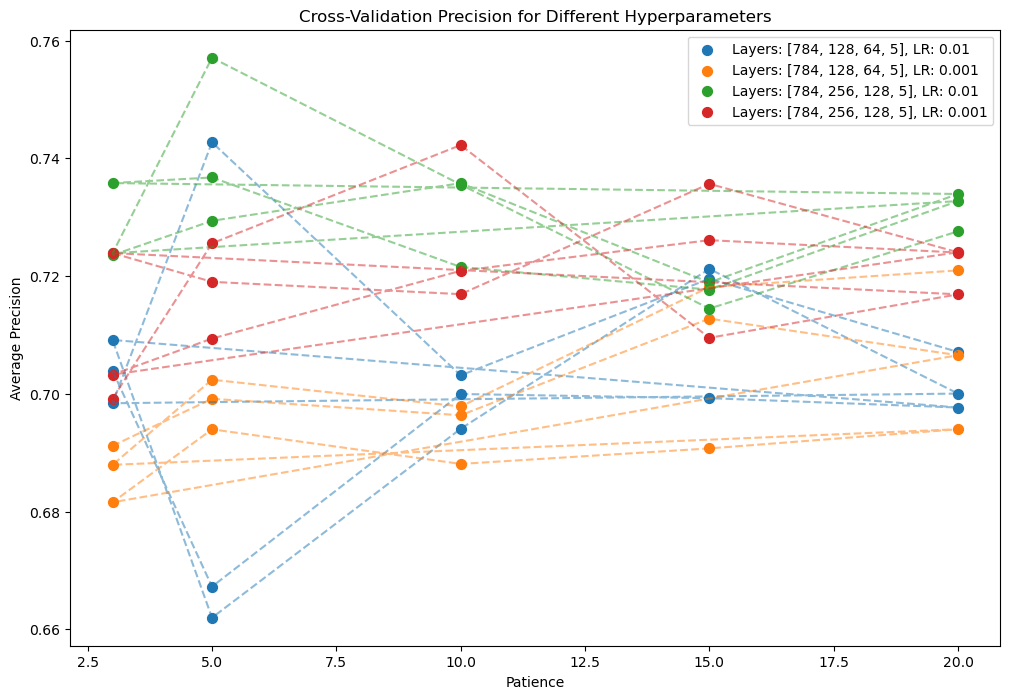

Epoch 1/150: Loss: 3.5948, Validation Precision: 0.7611
Epoch 2/150: Loss: 2.5227, Validation Precision: 0.7344
Epoch 3/150: Loss: 2.8515, Validation Precision: 0.7312
Epoch 4/150: Loss: 2.4931, Validation Precision: 0.7663
Epoch 5/150: Loss: 3.3379, Validation Precision: 0.7776
Epoch 6/150: Loss: 3.0935, Validation Precision: 0.7382
Epoch 7/150: Loss: 3.4691, Validation Precision: 0.7835
Epoch 8/150: Loss: 3.3343, Validation Precision: 0.7638
Epoch 9/150: Loss: 4.3846, Validation Precision: 0.7621
Epoch 10/150: Loss: 4.5969, Validation Precision: 0.7324
Epoch 11/150: Loss: 4.8001, Validation Precision: 0.7757
Epoch 12/150: Loss: 6.1576, Validation Precision: 0.7839
Epoch 13/150: Loss: 5.2370, Validation Precision: 0.7629
Epoch 14/150: Loss: 5.8065, Validation Precision: 0.7729
Epoch 15/150: Loss: 6.0010, Validation Precision: 0.7527
Epoch 16/150: Loss: 6.5143, Validation Precision: 0.7803
Epoch 17/150: Loss: 6.0307, Validation Precision: 0.7484
Early stopping triggered after 17 epochs

In [19]:
def train_and_evaluate(model, X_train, y_train, X_val, y_val, epochs, learning_rate, batch_size, patience):
    model.train_with_early_stopping(
        X_train, y_train, X_val, y_val,
        epochs=epochs,
        learning_rate=learning_rate,
        batch_size=batch_size,
        patience=patience,
        class_weights=class_weights  # {{ edit_1 }}
    )
    val_predictions = model.predict(X_val)
    val_precision = precision_score(
        np.argmax(y_val, axis=0),
        np.argmax(val_predictions, axis=0),
        average='weighted',
        zero_division=0
    )
    return val_precision

def cross_validate_with_patience(X, y, layer_sizes_options, learning_rate_options, epochs_options, patience_values, n_splits=3):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    results = []

    for layer_sizes in layer_sizes_options:
        for learning_rate in learning_rate_options:
            for epochs in epochs_options:
                for patience in patience_values:
                    fold_precisions = []
                    for train_index, val_index in kf.split(X):
                        X_train, X_val = X[train_index], X[val_index]
                        y_train, y_val = y[train_index], y[val_index]

                        # Transpose the data here to match the expected input of your NeuralNetwork
                        X_train, X_val = X_train.T, X_val.T
                        y_train, y_val = y_train.T, y_val.T

                        model = NeuralNetwork(layer_sizes)
                        val_precision = train_and_evaluate(
                            model, X_train, y_train, X_val, y_val,
                            epochs, learning_rate, batch_size=64, patience=patience
                        )
                        fold_precisions.append(val_precision)

                    avg_precision = np.mean(fold_precisions)
                    results.append((layer_sizes, learning_rate, epochs, patience, avg_precision))

    return results

# Prepare data
X_train, X_val, y_train, y_val = train_test_split(
    train_images_flat,  # Remove .T
    train_labels_one_hot,  # Remove .T
    test_size=0.2,
    random_state=42
)


# Define hyperparameters
layer_sizes_options = [[784, 128, 64, 5], [784, 256, 128, 5]]
learning_rate_options = [0.01, 0.001]
epochs_options = [50, 100, 150]
patience_values = [3, 5, 10, 15, 20]

# Perform cross-validation with patience
results = cross_validate_with_patience(
    X_train, y_train,
    layer_sizes_options,
    learning_rate_options,
    epochs_options,
    patience_values
)

# Find best configuration
best_config = max(results, key=lambda x: x[4])
print(f"Best configuration: Layers: {best_config[0]}, LR: {best_config[1]}, "
      f"Epochs: {best_config[2]}, Patience: {best_config[3]}, Precision: {best_config[4]:.4f}")

# Visualize results
fig, ax = plt.subplots(figsize=(12, 8))
for layer_sizes in layer_sizes_options:
    for lr in learning_rate_options:
        data = [(p, e, prec) for ls, l, e, p, prec in results if ls == layer_sizes and l == lr]
        if data:
            patience, epochs, precision = zip(*data)
            ax.scatter(patience, precision, label=f"Layers: {layer_sizes}, LR: {lr}", s=50)
            ax.plot(patience, precision, linestyle='--', alpha=0.5)

ax.set_xlabel('Patience')
ax.set_ylabel('Average Precision')
ax.set_title('Cross-Validation Precision for Different Hyperparameters')
ax.legend()
plt.savefig('cross_validation_precision_for_different_hyperparameters.png')
plt.show()

# Train final model with best configuration
best_model = NeuralNetwork(best_config[0])
best_model.train_with_early_stopping(
    X_train.T, y_train.T, X_val.T, y_val.T,  # Transpose the data here
    epochs=best_config[2],
    learning_rate=best_config[1],
    batch_size=64,
    patience=best_config[3],
    class_weights=class_weights  # {{ edit_2 }}
)

# Evaluate on validation set
val_predictions = best_model.predict(X_val.T)  # Transpose X_val
val_predictions_labels = np.argmax(val_predictions, axis=0)
val_labels_numeric = np.argmax(y_val, axis=1)  # Change axis to 1


print("\nBest Model Validation Results:")
print("Accuracy:", accuracy_score(val_labels_numeric, val_predictions_labels))
print(classification_report(val_labels_numeric, val_predictions_labels))

### Neural network from library

c:\Users\l\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Results:
Accuracy: 0.8244
              precision    recall  f1-score   support

           0       0.77      0.82      0.79      1000
           1       0.97      0.94      0.96      1000
           2       0.82      0.84      0.83      1000
           3       0.83      0.90      0.86      1000
           4       0.72      0.62      0.67      1000

    accuracy                           0.82      5000
   macro avg       0.82      0.82      0.82      5000
weighted avg       0.82      0.82      0.82      5000



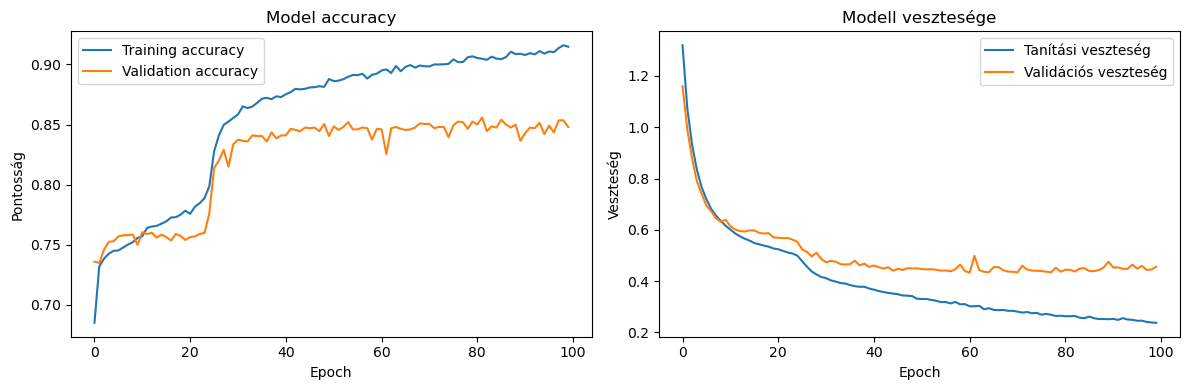

c:\Users\l\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Legjobb: 0.8966447495990852 használva a következő paramétereket: {'batch_size': 64, 'epochs': 10, 'optimizer': 'rmsprop'}


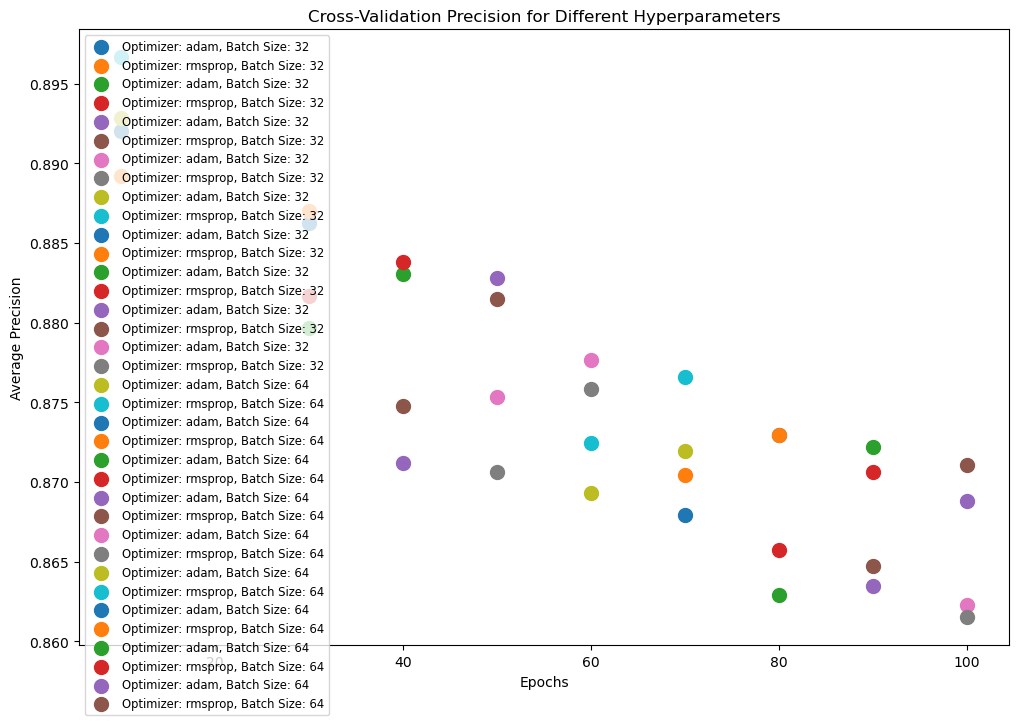

In [20]:
model = Sequential([
    Dense(64, activation='softmax', input_shape=(784,)),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_images_flat, train_labels_one_hot,
                    epochs=100, batch_size=32, validation_split=0.2, verbose=0)

predictions_tf = model.predict(test_images_flat)
predictions_tf_labels = np.argmax(predictions_tf, axis=1)

print("\nResults:")
print("Accuracy:", accuracy_score(test_labels, predictions_tf_labels))
print(classification_report(test_labels, predictions_tf_labels))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Pontosság')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Tanítási veszteség')
plt.plot(history.history['val_loss'], label='Validációs veszteség')
plt.title('Modell vesztesége')
plt.xlabel('Epoch')
plt.ylabel('Veszteség')
plt.legend()

plt.tight_layout()
plt.show()

# KerasClassifier becsomagolása
model = KerasClassifier(build_fn=model, verbose=0)
# Hiperparaméterek keresése
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'epochs': [10,30,40,50, 60, 70, 80, 90, 100],
    'batch_size': [32, 64]
}

# Keresztvalidáció
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='precision_weighted')

# Hiperparaméter keresés futtatása
grid_result = grid.fit(train_images_flat, train_labels_one_hot)

# Eredmények kiírása
print(f"Legjobb: {grid_result.best_score_} használva a következő paramétereket: {grid_result.best_params_}")

# Plot precision results
results = grid_result.cv_results_
mean_precision = results['mean_test_score']
params = results['params']

plt.figure(figsize=(12, 8))
for mean, param in zip(mean_precision, params):
    plt.scatter(param['epochs'], mean, label=f"Optimizer: {param['optimizer']}, Batch Size: {param['batch_size']}", s=100)

plt.xlabel('Epochs')
plt.ylabel('Average Precision')
plt.title('Cross-Validation Precision for Different Hyperparameters')
plt.legend(loc='best', fontsize='small')
plt.savefig('cross_validation_precision_for_different_hyperparameters_fromlibrary.png')
plt.show()

### Model 3: CNN

In [21]:
# Adatok előkészítése
train_images_cnn = train_images[..., np.newaxis]  # Add channel dimension
test_images_cnn = test_images[..., np.newaxis]

# CNN modell létrehozása
def create_cnn_model(optimizer='adam', dropout_rate=0.5):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# KerasClassifier becsomagolása
model = KerasClassifier(build_fn=create_cnn_model, verbose=0,dropout_rate=0.3)

# Hiperparaméterek keresése
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.3, 0.5, 0.7],
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

# Keresztvalidáció
kfold = KFold(n_splits=3, shuffle=True, random_state=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, n_jobs=-1)

# Hiperparaméter keresés futtatása
grid_result = grid.fit(train_images_cnn, train_labels_one_hot)

# Eredmények kiírása
print(f"Legjobb: {grid_result.best_score_} használva a következő paramétereket: {grid_result.best_params_}")

# Legjobb modell újraépítése a legjobb paraméterekkel
best_params = grid_result.best_params_
best_model = create_cnn_model(optimizer=best_params['optimizer'], dropout_rate=best_params['dropout_rate'])
best_model.fit(train_images_cnn, train_labels_one_hot, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

# Legjobb modell kiértékelése a teszt adatokon
test_loss, test_accuracy = best_model.evaluate(test_images_cnn, test_labels_one_hot, verbose=0)
print(f"Teszt pontosság: {test_accuracy}")

c:\Users\l\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\l\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Legjobb: 0.8866003276992366 használva a következő paramétereket: {'batch_size': 32, 'dropout_rate': 0.5, 'epochs': 20, 'optimizer': 'adam'}
Teszt pontosság: 0.8884000182151794
